In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from matplotlib.colors import ListedColormap

'''
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.quilbase import Declare
'''
from DataSet import DataSet

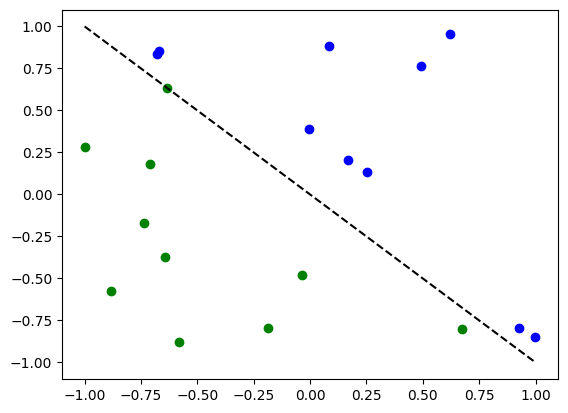

[[-0.1885798  -0.79329234]
 [-0.58303089 -0.88103033]
 [ 0.08584878  0.88304761]
 [-0.88324856 -0.57569089]
 [-0.00571152  0.39011241]
 [-0.66916841  0.85271794]
 [-0.6437634  -0.37376798]
 [ 0.92659205 -0.79214343]
 [-0.99909316  0.27994945]
 [ 0.99816675 -0.84774699]
 [-0.73634672 -0.16705383]
 [-0.0360251  -0.48226306]
 [ 0.16985159  0.20272083]
 [ 0.49360713  0.76309735]
 [ 0.67403341 -0.80224786]
 [-0.67835984  0.83372227]
 [ 0.2529293   0.13467263]
 [-0.63372347  0.63275044]
 [-0.71026711  0.18405963]
 [ 0.62043783  0.95292067]]
[-1 -1  1 -1  1  1 -1  1 -1  1 -1 -1  1  1 -1  1  1 -1 -1  1]
[0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1]


In [2]:
#Instanciamos la clase DataSet y mostramos un diagrama los datos
dataset = DataSet()
dataset.Draw()

print(dataset.X_aux)
print(dataset.y)
print(dataset.y01)

In [3]:
dev = qml.device("default.qubit")

In [4]:
def layer(layer_weights):
    for wire in range(1):
        qml.Rot(*layer_weights[wire], wires=wire)

    qml.CNOT([0, 1])

In [5]:
def state_preparation(x):
    '''
    program = Program()

    program.inst(RY(x[0], qubit = 0))
    program.inst(RY(x[0], qubit = 1))
    program.inst(CNOT(0, 1))
    program.inst(RY(x[0], qubit = 0))
    program.inst(RY(x[0], qubit = 1))
    program.inst(CNOT(0, 1))
    program.inst(RY(x[0], qubit = 0))
    program.inst(RY(x[0], qubit = 0))
    program.inst(CNOT(0, 1))
    program.inst(RY(x[0], qubit = 0))
    program.inst(RY(x[0], qubit = 1))

    qml_circuit = qml.from_pyquil(program)

    '''
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])

    qml.RZ(x[0], wires=0)
    qml.RZ(x[0], wires=1)
    
    qml.CNOT(wires=[0, 1])
    qml.Hadamard(wires=0)


In [6]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [7]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [8]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [9]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [10]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [11]:
for x,y in zip(dataset.y01, dataset.y):
    print(f"x = {x}, y = {y}")

x = 0, y = -1
x = 0, y = -1
x = 1, y = 1
x = 0, y = -1
x = 1, y = 1
x = 1, y = 1
x = 0, y = -1
x = 1, y = 1
x = 0, y = -1
x = 1, y = 1
x = 0, y = -1
x = 0, y = -1
x = 1, y = 1
x = 1, y = 1
x = 0, y = -1
x = 1, y = 1
x = 1, y = 1
x = 0, y = -1
x = 0, y = -1
x = 1, y = 1


In [12]:
np.random.seed(0)
num_qubits = 2
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]]

 [[ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]]
Bias:  0.0


In [13]:
weights = weights_init
bias = bias_init

# Update the weights by one optimizer step, using only a limited batch of data
batch_index = np.random.randint(0, len(dataset.y01), (batch_size,))
X_batch = dataset.y01[batch_index]
Y_batch = dataset.y[batch_index]

# Compute accuracy
predictions = [np.sign(variational_classifier(weights, bias, dataset.y01)) for x in dataset.y01]

#current_cost = cost(weights, bias, dataset.y01, dataset.y)
acc = accuracy(dataset.y, predictions)

print(f"Iter: {1}  | Accuracy: {acc:0.7f}")

Iter: 1  | Accuracy: 0.5000000


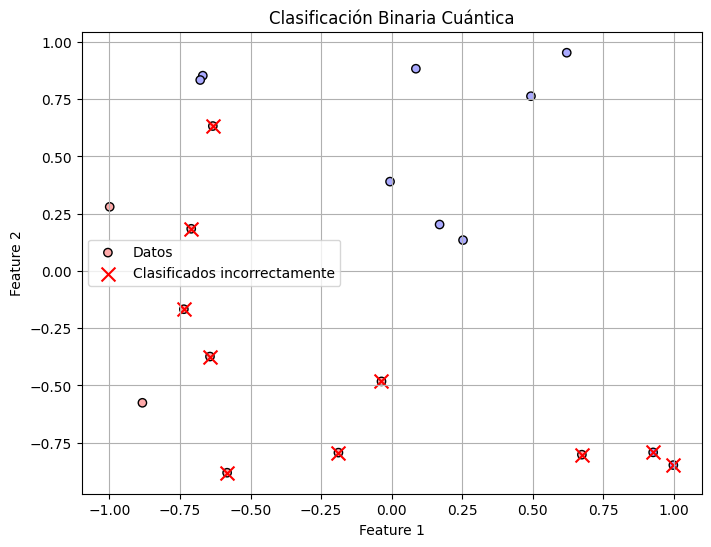

In [14]:
misclassified_indices = []

# Calcula las predicciones para cada punto y almacena los índices de los mal clasificados
predictions = [np.sign(variational_classifier(weights, bias, x)) for x in dataset.X_aux]
for idx, (prediction, label) in enumerate(zip(predictions, dataset.y)):
    if prediction != label:
        misclassified_indices.append(idx)

# Plotea los datos
plt.figure(figsize=(8, 6))
plt.scatter(dataset.X_aux[:, 0], dataset.X_aux[:, 1], c=dataset.y, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), marker='o', edgecolors='k', label='Datos')

# Plotea los puntos clasificados incorrectamente
incorrectly_classified = dataset.X_aux[misclassified_indices]
plt.scatter(incorrectly_classified[:, 0], incorrectly_classified[:, 1], c='red', marker='x', s=100, label='Clasificados incorrectamente')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clasificación Binaria Cuántica')
plt.legend()
plt.grid(True)
plt.show()